In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, accuracy_score

import pmdarima as pm
import statsmodels.api as api
from scipy.stats import norm

from utils import import_wl_data, import_ph_data, take_derivative, cut_ends, unit_scale
from models.data_validation import ReportErrors

import warnings
warnings.filterwarnings('ignore')

In [6]:
metadata = pd.read_csv("data/metadata.csv")
pH_meta = pd.read_csv("data/wq_metadata - pH.csv")
depth120d = pd.read_csv("data/metadata - 120d.csv")

# Figure 1

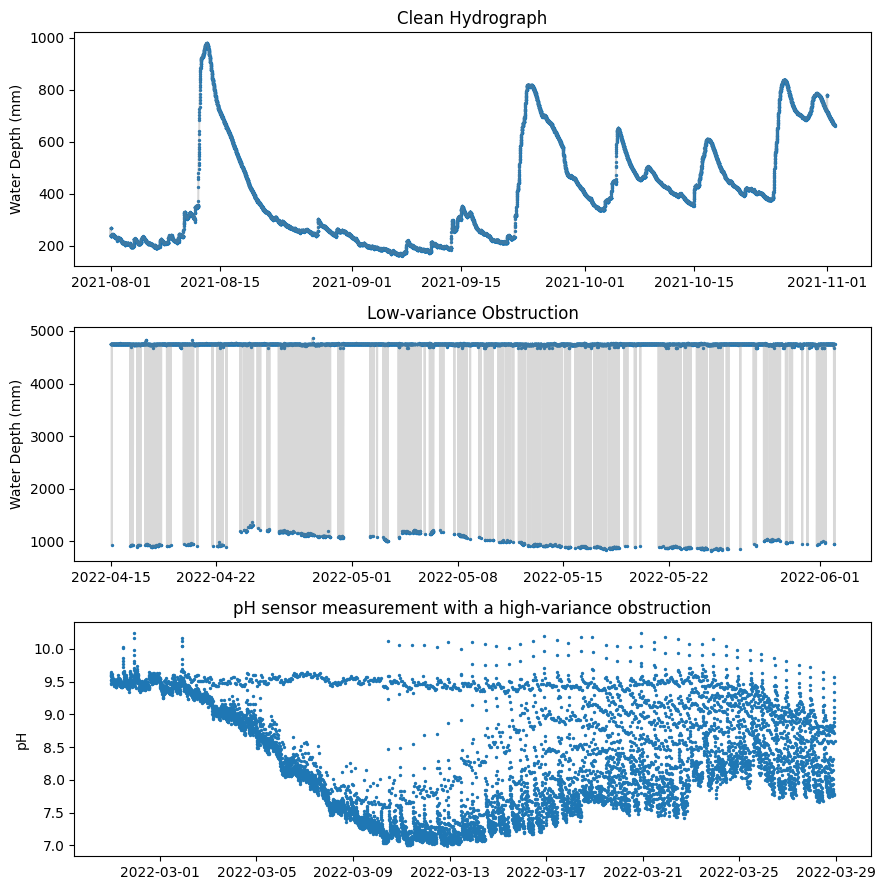

In [3]:
clean_site = import_wl_data(index = 22)
clean_site = clean_site['2021-08-01':'2021-11-01']
lo_var = import_wl_data(index=101)
lo_var = lo_var['2022-04-15':'2022-06-01']
col = pH_meta.iloc[80]
hi_var = import_ph_data(col['node_id'], col['start'], col['end'])

fig, ax = plt.subplots(nrows=3,figsize=(9,9))
ax[0].scatter(clean_site.index, clean_site['Value'], s=2)
ax[0].plot(clean_site.index, clean_site['Value'], c='grey', alpha=0.3)
ax[1].scatter(lo_var.index, lo_var['Value'], s=2)
ax[1].plot(lo_var.index, lo_var['Value'], c='grey', alpha=0.3)
ax[2].scatter(hi_var.index, hi_var['Value'], s=2)
ax[0].set_title("Clean Hydrograph")
ax[1].set_title("Low-variance Obstruction")
ax[2].set_title("pH sensor measurement with a high-variance obstruction")
ax[0].set_ylabel("Water Depth (mm)")
ax[1].set_ylabel("Water Depth (mm)")
ax[2].set_ylabel("pH")
plt.tight_layout()

# Figure 2

In [45]:
### Define the data for the clean hydrograph ###
df = import_wl_data(index = 82)
df = df[df['Value'] < 1400] # cuts out a few outliers
df = df['2021-08':'2022-01-20']
sub_df = df["2021-10-25 00:00:00+00:00":"2021-10-30 00:00:00+00:00"]
df, df_down, df_up = take_derivative(df)
sub_df, sub_df_down, sub_df_up = take_derivative(sub_df)
### Define the data for the obstructed hydrograph ###
obst = import_wl_data(index = 68)
obst_plot = obst[obst['Value'] >0]
obst_plot = obst_plot[obst_plot['Value'] < 1200]
obst_c = cut_ends(obst)
obst_c, obst_down, obst_up = take_derivative(obst_c)

### Manually highlight clusters of obstructed data ###
outliers_1 = np.where(obst_down['Value'] > 800, -1, 0)
outliers_2 = np.where(obst_down['mean diff'] < -0.012, -1, 0)
outliers_3 = np.where(obst_down['mean diff'] > -0.0025, -1, 0)
outliers = np.where(outliers_1 + outliers_2 + outliers_3== -2, -1, 0)
### Define the data for the second obstructed hydrograph ###
obst2 = import_wl_data(index = 13)
obst2, obst2_down, obst2_up = take_derivative(obst2)
# derv_fault = obst2[obst2['mean diff']<=-0.001]
# np.where()
derv_fault = np.where(obst2_down['mean diff']<=-0.001, -1, 0)

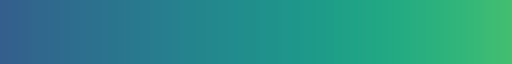

In [46]:
### Define a trimmed version of viridis to keep colors consistent ###
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('viridis')
short_viridis = truncate_colormap(cmap, 0.3, 0.7)
short_viridis

(190.0, 1040.6000000000001)

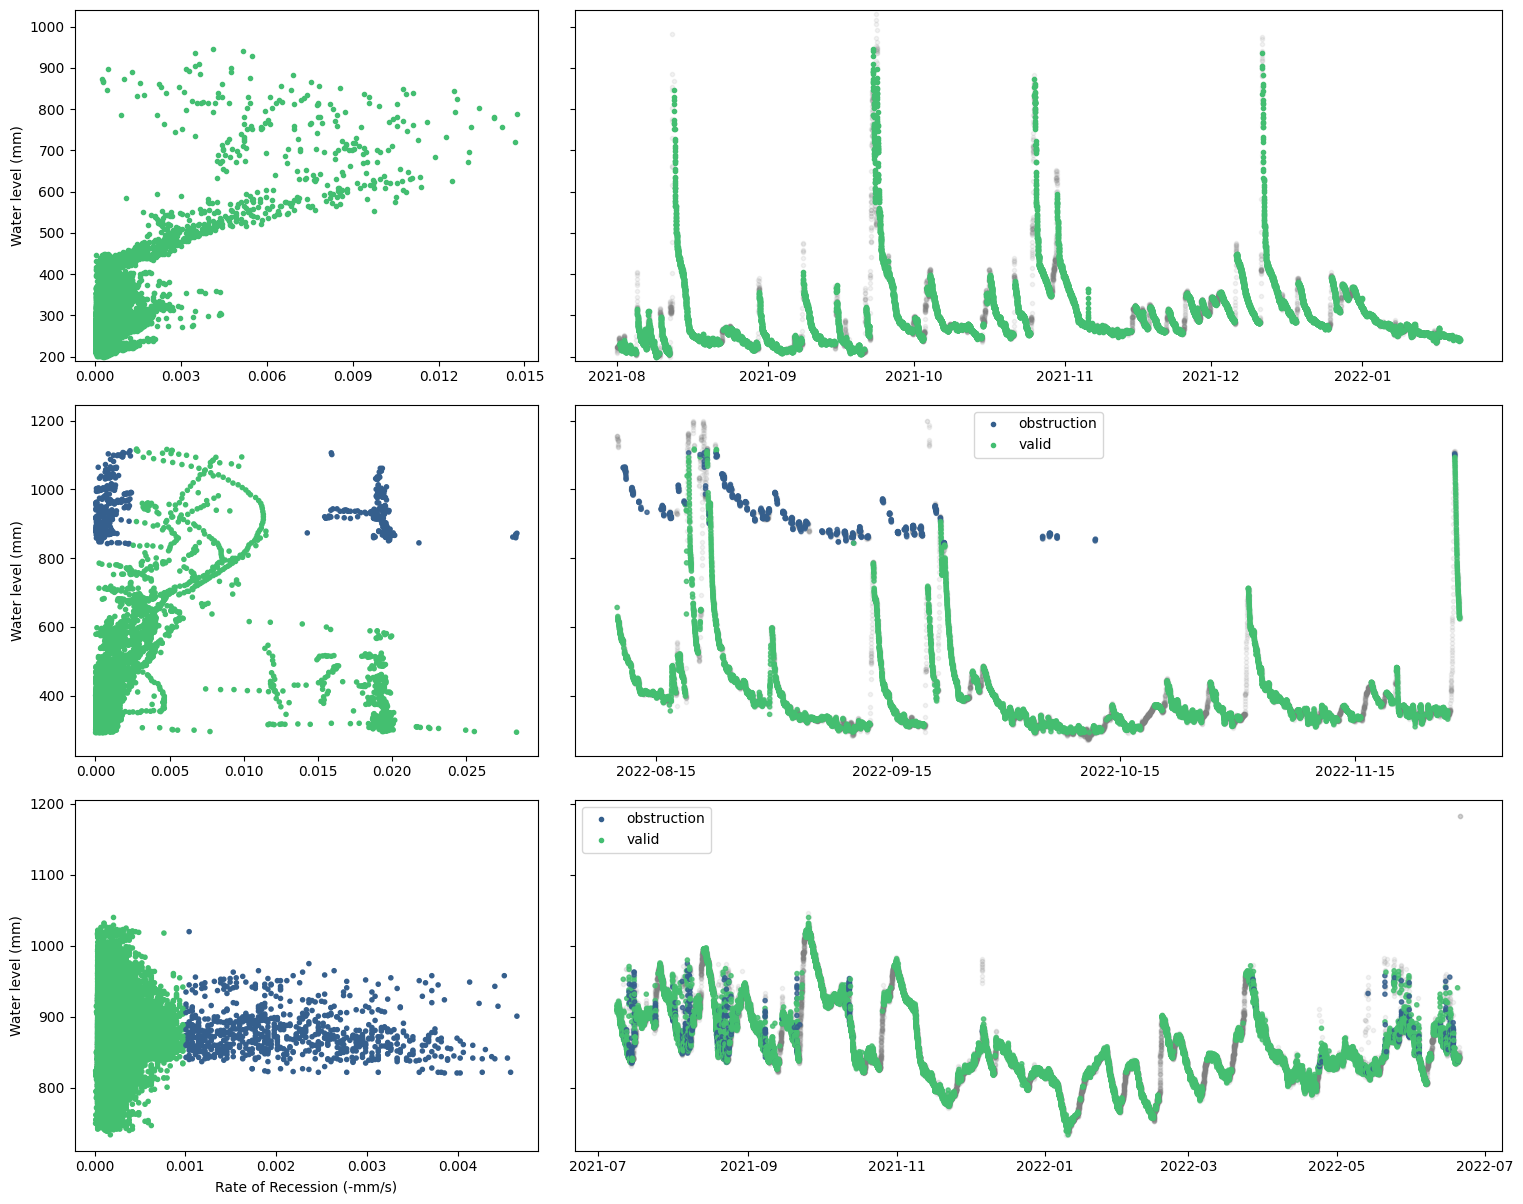

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize = (15, 12), sharey='row',
                       gridspec_kw={'width_ratios': [1, 2]})
plt.tight_layout()
ax[0,1].scatter(df.index, df['Value'], marker = '.', color='grey', alpha=0.1)
ax[0,0].scatter(-1*df_down['mean diff'], df_down['Value'], marker='.', color=short_viridis(0.99))
ax[0,1].scatter(df_down.index, df_down['Value'], color=short_viridis(0.99), marker = '.')
ax[0,0].set_ylabel('Water level (mm)')
ax[0,0].set_xticks([0.000, 0.003, 0.006, 0.009, 0.012, 0.015])

ax[1,0].scatter(-1*obst_down['mean diff'], obst_down['Value'], marker='.', c=outliers, cmap=short_viridis)
ax[1,1].scatter(obst_plot.index, obst_plot['Value'], marker='.', c='grey', alpha=0.1)
ax[1,1].scatter(obst_down.index, obst_down['Value'], marker='.', c=outliers, cmap=short_viridis, alpha=0.8)
ax[1,1].set_xticks(['2022-08-15', '2022-09-15', '2022-10-15', '2022-11-15'])
ax[1,0].set_ylabel('Water level (mm)')

ax[2,0].set_xlabel('Rate of Recession (-mm/s)')
legend_elements = [Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=short_viridis(0),
                          c=short_viridis(0), label='obstruction'),
                   Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=short_viridis(0.99),
                          c=short_viridis(0.99), label='valid',)]
ax[1,1].legend(handles=legend_elements)

ax[2,0].scatter(-1*obst2_down['mean diff'], obst2_down['Value'], marker='.', c=derv_fault, cmap=short_viridis)
ax[2,1].scatter(obst2.index, obst2['Value'], marker='.', c='grey', alpha=0.1)
ax[2,1].scatter(obst2_down.index, obst2_down['Value'], marker='.', c=derv_fault, cmap=short_viridis, alpha=0.8)
ax[2,0].set_ylabel('Water level (mm)')
ax[2,1].legend(handles=legend_elements)
ax[0,1].set_ylim([0.95*min(df_down['Value']), 1.1*max(df_down['Value'])])


# Figure 4

In [18]:
def get_arima_fit(data):
    '''
    Adapted from PyhydroQC (https://github.com/AmberSJones/pyhydroqc)
    Automatically tunes and fits an ARIMA model on 1D time series data.
    Arguments:
        pandas dataframe with timeseries data in a column called 'Value'
    Returns: 
        model predictions and residuals.
    '''
    model = pm.auto_arima(np.array(data), seasonal=False, suppress_warnings=True, error_action="ignore")
    (p, d, q) = model.order
    model = api.tsa.SARIMAX(data, order=(p, d, q))
    model_fit = model.fit(disp=0, warn_convergence=False)
    residuals = pd.DataFrame(model_fit.resid)
    residuals[0][0] = 0
    predict = model_fit.get_prediction()
    predictions = pd.DataFrame(predict.predicted_mean)
    predictions['predicted_mean'][0] = data['Value'][0]
    return predictions, residuals

def set_dynamic_threshold(residuals, window_sz=144, alpha=0.01, min_range=0.0):
    """
    Adapted from PyhydroQC (https://github.com/AmberSJones/pyhydroqc)
    set_dynamic_threshold determines a threshold for each point based on the local confidence interval
    considering the model residuals looking forward and backward a specified number of steps.
    Arguments:
        residuals: series like object or a data frame of model residuals.
        alpha: scalar between 0 and 1 representing the acceptable uncertainty.
        window_sz: integer representing how many data points to use in both directions.
            default = 144 for one day for 10-minute data.
    Returns:
        threshold: data frame of columns of low and high threshold values.
    """
    threshold = []  # initialize empty list to hold thresholds
    z = norm.ppf(1 - alpha / 2)

    # if the window size parameter is too big for this data set
    if (window_sz > len(residuals)):
        print("WARNING: in set_dynamic_threshold(), window_sz > len(data)! Reducing window_sz.")
        window_sz = len(residuals)  # reduce the window to the max allowable

    # loop through data and add each threshold pair
    for i in range(0, len(residuals)):
        if (window_sz > i):  # index is closer than window size to left edge of data
            lo = 0
        else:  # look back as far as the window size
            lo = i - window_sz
        if (i + window_sz > len(residuals)):  # index is close to right edge of data
            hi = len(residuals)
        else:  # look forward as far as the window size
            hi = i + window_sz

        # calculate the range of probable values using given alpha
        mean = np.mean(residuals[lo:(hi + 1)])[0]#.mean()
        sigma = np.std(residuals[lo:(hi + 1)])[0]#.std()
        th_range = z * sigma
        if (th_range < min_range):
            th_range = min_range
        # append pair of upper and lower thresholds
        threshold.append([mean - th_range, mean + th_range])

    threshold = pd.DataFrame(threshold, columns=['low', 'high'])

    return threshold

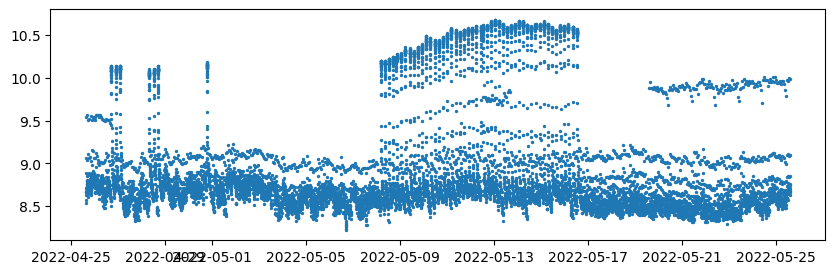

In [14]:
col = pH_meta.iloc[12]
data = import_ph_data(col['node_id'], col['start'], col['end'])
fig, ax = plt.subplots(figsize=(10,3))
plt.scatter(data.index, data['Value'], s=2)

In [20]:
predictions, residuals = get_arima_fit(data[['Value']])
mean = data['Value'].rolling(window='1D', min_periods=1, center=True).mean()
std = data['Value'].rolling(window='1D', min_periods=1, center=True).std()
threshold = set_dynamic_threshold(residuals, window_sz=72)

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


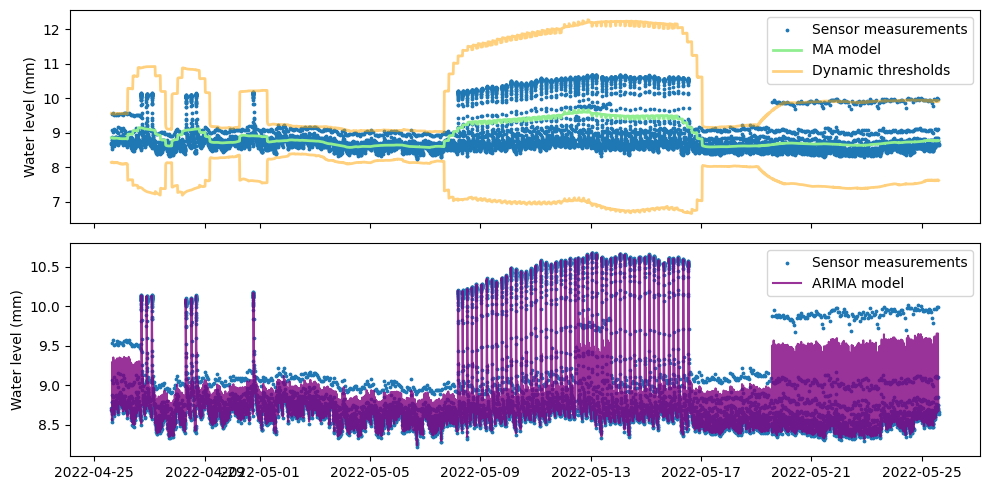

In [23]:
sub = data
predsub=predictions

fig, ax = plt.subplots(figsize=(10, 5), nrows=2, sharex=True)

ax[0].scatter(sub.index, sub['Value'], s=3, label='Sensor measurements')
ax[0].plot(sub.index, mean, linewidth=2, c='lightgreen', label='MA model')
ax[0].plot(sub.index, mean+3*std, linewidth=2, c='orange', label='Dynamic thresholds', alpha=0.5)
ax[0].plot(sub.index, mean-3*std, linewidth=2, c='orange', alpha=0.5)
ax[1].scatter(sub.index, sub['Value'], s=3, label='Sensor measurements')
ax[1].plot(predsub.index, predsub['predicted_mean'], c='purple', alpha=0.8, label='ARIMA model')
ax[0].legend()
ax[1].legend()

ax[0].set_ylabel("Water level (mm)")
ax[1].set_ylabel("Water level (mm)")
plt.tight_layout()

In [30]:
def svm_classification(data, y, scoring = 'accuracy'):
    params = [{'kernel':['linear', 'rbf', 'poly'], 'C':[0.1, 1, 10, 100]}]
    clf_pipe = SVC()
    gs_clf = GridSearchCV(clf_pipe, param_grid=params, scoring=scoring, cv=5)
    gs_clf.fit(data, y)
    return gs_clf.best_params_

def cut_ends(df):
    try:
        q1, q99 = df['Value'].quantile([0.005, 0.995])
        a = df.copy()
        if len(df[df['Value']<q1]) < 0.02*len(df): 
            a = df[df['Value']>q1]
        if len(a[a['Value']>q99]) < 0.02*len(df):
            a = a[a['Value']<q99]
        return a
    except:
        return df
    
def add_derv(df, tol = 0.00001):
    df = df.copy()
    df['smoothed'] = df['Value'].rolling(window=6*8, min_periods=1, center=True).mean()
    df['mean diff'] = df['smoothed'].diff(1).fillna(0) / df.index.to_series().diff(periods=1).dt.seconds #careful for non-USGS data
    df = df.drop(df[df['mean diff'] < -1e308]['mean diff'].index)
    df_down = df[df['mean diff'] < -1*tol]
    df_up = df[df['mean diff'] >= tol]
    
    return df, df_down, df_up

def validate_depth(metadata, dataset='level', nbins=10, cv_k=5, dim=2, model='svm', 
                   scoring = 'accuracy'):
    
    df = metadata.copy()
    df['flag'] = np.zeros(len(df))
    class_X = []
    class_i = []
    class_y = []
    
    if dataset == 'level':
        tol=1e-4
    else:
        tol=1e-6
    
    for row, col in df.iterrows():
        if dataset =='level':
            data = import_wl_data(node_id=col['Node ID'], site_id=col['Site ID'])
            data = data[col['start']:col['end']]
            label = col['Clean']
            offset = col['Offset (mm)']
        elif dataset == 'pH':
            data = import_ph_data(col['node_id'], col['start'], col['end'])
            label = col['clean']
        elif dataset == 'ec':
            data = import_ec_data(col['node_id'], col['start'], col['end'])
            label = col['clean']
        
        if len(data) == 0:
            df['flag'].iloc[row] = 1
        else:
            if dataset == 'level':
                data, flag = flag_depth_errors(data, offset) # this function needs to be specified to type of sensor
            elif dataset == 'pH':
                data, flag = flag_ph_errors(data)
            elif dataset == 'ec':
                data, flag = flag_ec_errors(data)
                
            if flag:
                df['flag'].iloc[row] = 1
            else:
                if dataset !='level':
                    if len(data) > 100:
                        data = cut_ends(data)
                
                depth, depth_down, depth_up = add_derv(data, tol=tol)
                if len(depth_down) == 0:
                    df['flag'].iloc[row] = 1
                else:
                    X = np.array(depth_down[['Value', 'mean diff']])
                    if dim == 2:
                        h, x_e, y_e = np.histogram2d(X[:,0], X[:,1], nbins)
                    else:
                        h, x_e = np.histogram(X[:,0], nbins)
                    h = np.reshape(h, (-1,1))
                    mm = make_pipeline(StandardScaler(), MinMaxScaler())
                    h = mm.fit_transform(h)
                    class_i.append(row)
                    class_X.append(np.ndarray.flatten(h))
                    class_y.append(label)
    
    y = np.array(class_y)
    X = np.array(class_X)

    if model == 'mlp':
        best_params = mlp_classification(X, y, scoring=scoring)
        m = MLPClassifier(alpha=best_params['alpha'], 
                            random_state=best_params['random_state'],
                            hidden_layer_sizes = best_params['hidden_layer_sizes'],)
    elif model == 'svm':
        best_params = svm_classification(X, y, scoring=scoring)
        m = SVC(kernel=best_params['kernel'], C=best_params['C'])
    elif model == 'nb':
        best_params = nb_classification(X, y, scoring=scoring)
        m = GaussianNB(var_smoothing=best_params['var_smoothing'])
    elif model == 'ada':
        best_params = ada_classification(X, y, scoring=scoring)
        m = AdaBoostClassifier(n_estimators=best_params['n_estimators'])
    elif model == 'gp':
        best_params = gp_classification(X, y, scoring=scoring)
        m = GaussianProcessClassifier(kernel=best_params['kernel'])
    elif model == 'knn':
        best_params = knn_classification(X, y, scoring=scoring)
        m = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
    else:
        return 0, -1
    
    y_pred = cross_val_predict(m, X, y, cv=cv_k)

    classified = pd.DataFrame({'y': y, 'prediction': y_pred})
    classified.index = class_i
    
    if dataset == 'level':
        testdf = df[df['flag']==1]['Clean']
    else:
        testdf = df[df['flag']==1]['clean']
        
    flagged = pd.DataFrame({'y': testdf, 'prediction': np.zeros(len(testdf))})
    
    final_class = pd.concat([classified, flagged])
    
    return final_class['prediction'], final_class['y']

In [35]:
acc_N_120d_ns = []
for N in range(30, 185):
    acc = []
    prec = []
    fnr = []
    fpr = []
    for i in range(10):
        stratified_sample, _ = train_test_split(depth120d, test_size=abs(len(depth120d) - N)/len(depth120d), 
                                                random_state=i)
        stratified_sample.index = [i for i in range(len(stratified_sample))]
        y_pred, y = validate_depth(stratified_sample, dim=2, model='svm', 
                                   nbins=[10,4], scoring='accuracy')
        acc.append(accuracy_score(y, y_pred))
        prec.append(precision_score(y, y_pred))
        C = confusion_matrix(y, y_pred)
        fnr.append(C[1,0])
        fpr.append(C[0,1])
                
    if N %10 ==0:
        print(f"completed N={N}")
    acc_N_120d_ns.append({'N': N, 'accuracy': np.mean(acc), 'precision': np.mean(prec), 
                      'no. fn': np.mean(fnr), 'no. fp': np.mean(fpr)})

completed N=30
completed N=40
completed N=50
completed N=60
completed N=70
completed N=80
completed N=90
completed N=100
completed N=110
completed N=120
completed N=130
completed N=140
completed N=150
completed N=160
completed N=170
completed N=180


In [36]:
accbyN = pd.DataFrame(acc_N_120d_ns)

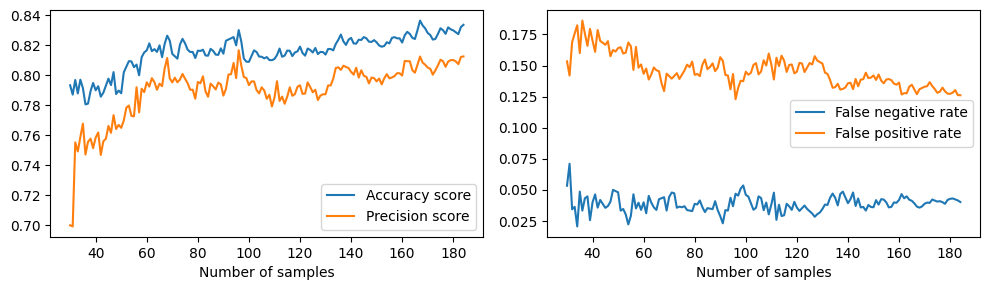

In [37]:
fig, ax = plt.subplots(figsize=(10, 3), ncols=2)
ax[0].plot(accbyN['N'], accbyN['accuracy'], label="Accuracy score")
ax[0].plot(accbyN['N'], accbyN['precision'], label="Precision score")
ax[1].plot(accbyN['N'], accbyN['no. fn']/accbyN['N'], label='False negative rate')
ax[1].plot(accbyN['N'], accbyN['no. fp']/accbyN['N'], label='False positive rate')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("Number of samples")
ax[1].set_xlabel("Number of samples")

plt.tight_layout()